# Proyecto: 
## TEL341 SIMULACIÓN DE REDES 2020-1
### *Matías Concha Arellano- 201530017-8*
### *Ma. Fda. Rivas M-F - 201584033-4*
### *Jorge Fernández*


### Importación de bibliotecas del simulador

In [1]:
from statistics import mean, stdev
from random import random, seed
from datetime import datetime
from math import log, trunc
from copy import deepcopy
import topology as top
import plots as plts

### Obtención de datos para la simulación.

In [2]:
ON, OFF, NO_CHANNEL = 1, 0, -1
WIRES, WAVELENGTHS = 3, 18
WIRE_MODEL = [[840, 1], [850, 1], [860, 1], [870, 1], [880, 1], [890, 1], [900, 1], [910, 1], [920, 1],
    [930, 1], [940, 1], [950, 1], [960, 1], [970, 1], [980, 1], [990, 1], [1000, 1], [1100, 1]]

### Parámetros del Simulador

In [3]:
i = 6
N = 10  # Cantidad de nodos
M = N * (N - 1)  # cantidad usuarios (90)

t_on = 0.001
rho = 0.15
t_off = t_on * ((1 - rho) / rho)

mu = 1 / t_on
lamb = 1 / (t_on + t_off)
lambPrima = 1 / t_off

links = []
for link in range(N):
    links.append(
        list([deepcopy(WIRE_MODEL), deepcopy(WIRE_MODEL), deepcopy(WIRE_MODEL)]))
routes_per_user = top.get_user_routes(N)

### Función generadora de números aleatorios con una distribución exponencial.

In [4]:
def randExp(n):
    seed(datetime.now())
    u = random()
    return (-1 / n) * log(u)

### Definición de la función de simulación del sistema

* ***FEL***: *Future Event List* consiste en una lista de tuplas *(id de usuario, **ESTADO**, tiempo futuro de cambio de estado)* que representa la lista de eventos futuros de la simulación para cada usuario.

* ***ESTADOS*** posibles:

  * 0: OFF (Usuario no está transmitiendo)
  * 1: ON (Usuario transmitiendo)
  * -1: BLOCKED (Usuario bloqueado)

*Para efectos de la simulación, los usuarios en off y blocked serán tratados de igual forma, pero se les asigna un estado diferente para poder diferenciarlos al inspeccionar el FEL.*

* #### Definición de las variables internas de la simulación

  * users: lista de tuplas que almacenan contadores de la cantidad de bloqueos y cantidad de llegadas de cada usuario al sistema.
  * links: la capacidad en tiempo real de cada enlace del sistema.

#### La salida de la simulación es una tupla con:
0. Un dataframe que contiene datos relevantes de la simulación, entre ellos, la probabilidad de bloqueo promedio por usuario y la canidad de saltos de cada usuario.
1. La probabilidad de bloqueo total de la topología ingresada



In [5]:
def simulator(M, N, links, routes_per_user, m, l, lp, i, load_balance):
    B = 0
    arrivals = 0
    arrivals_list = []
    user_history = []
    blk_100_network = []
    blk_prob_per_user = []
    blk_100_per_user = []
    blk_100_per_link = [[]] * N
    load_stdev = []
    total_network_sums = [54, 54, 54, 54, 54, 54, 54, 54, 54, 54]
    # Inicialización de la FEL
    FEL = []
    for _uid in range(M): # valores iniciales del FEL
        FEL.append(tuple((_uid, ON, NO_CHANNEL, randExp(l))))
        user_history.append([0, 0])
        blk_prob_per_user.append(0)
        blk_100_per_user.append([])
    
    while arrivals < 10**i:
        # Se ordena la FEL para conocer el evento próximo
        FEL = sorted(FEL, key=lambda item: item[3])
        
        # Se obtienen los datos del evento actual
        user_id, event, asigned_channel, current_time = FEL[0][0], FEL[0][1], FEL[0][2], FEL[0][3]
        # Se agrega un nuevo elemento a la FEL con el tiempo de llegada para el
        # mismo usuario.

        if event == ON:    
            is_successful_clock, chosen_channel_clock, sum_clock, total_network_sums = top.get_load_balance(
                routes_per_user[user_id][2][0], links, total_network_sums)

            is_successful_counterclock, chosen_channel_counterclock, sum_counterclock, total_network_sums = \
            top.get_load_balance(routes_per_user[user_id][2][1], links, total_network_sums)

            clock_hops = routes_per_user[user_id][2][0]
            counterclock_hops = routes_per_user[user_id][2][1]

            user_history[user_id][1] += 1
            arrivals += 1

            if is_successful_clock and is_successful_counterclock:
                if (sum_clock >= sum_counterclock and load_balance) \
                or (clock_hops < counterclock_hops and not load_balance):
                    top.change_preferred_route(routes_per_user[user_id][2][0], links, chosen_channel_clock, event)
                    FEL[0] = (user_id, OFF, chosen_channel_clock, current_time + randExp(m))
                else:
                    top.change_preferred_route(routes_per_user[user_id][2][1], links, chosen_channel_counterclock, event)
                    FEL[0] = (user_id, OFF, chosen_channel_counterclock, current_time + randExp(m))

            elif is_successful_clock and (not is_successful_counterclock):
                top.change_preferred_route(routes_per_user[user_id][2][0], links, chosen_channel_clock, event)
                FEL[0] = (user_id, OFF, chosen_channel_clock, current_time + randExp(m))

            elif (not is_successful_clock) and is_successful_counterclock:
                top.change_preferred_route(routes_per_user[user_id][2][1], links, chosen_channel_counterclock, event)
                FEL[0] = (user_id, OFF, chosen_channel_counterclock, current_time + randExp(m))

            else:
                FEL[0] = (user_id, ON, NO_CHANNEL, current_time + randExp(l))
                user_history[user_id][0] += 1                
                B += 1

        elif event == OFF:
            top.change_preferred_route(routes_per_user[user_id][2][1], links, asigned_channel, event)
            FEL[0] = (user_id, ON, NO_CHANNEL, current_time + randExp(lp))

        if arrivals % 10**(i-3) == 0 and arrivals > 0:
            load_stdev.append(stdev(total_network_sums))
            blk_100_network.append(B / arrivals)
            for _uid in range(M):
                if user_history[_uid][1] > 0:
                    blk_100_per_user[_uid].append(user_history[_uid][0] / user_history[_uid][1])
        
        if arrivals % 10**(i-2) == 0 and arrivals > 0:              
            for _link in range(N):
                blk_100_per_link[_link].append(total_network_sums[_link])
            arrivals_list.append(arrivals)

    #for uid in range(M):      
        #blk_prob_per_user[uid] = user_history[uid][0] / user_history[uid][1] 

    return blk_100_network, blk_100_per_user, blk_100_per_link, load_stdev, arrivals_list, total_network_sums

### Implementación de la simulación

Obtención de todos los datos necesarios para implementar la simulación de forma general.

Esta función queda parametrizada en el nombre de la topología de la red a simular.

In [6]:
balanced_data = simulator(M, N, links, routes_per_user, mu, lamb, lambPrima, i, True)

In [7]:
non_balanced_data = simulator(M, N, links, routes_per_user, mu, lamb, lambPrima, i, False)

### Gráficos de resultados

130


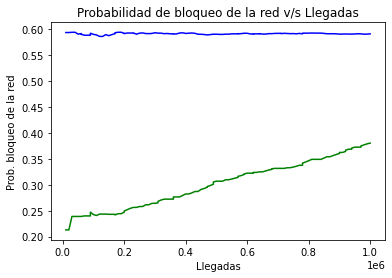

In [8]:
plts.plt_network(balanced_data, non_balanced_data)

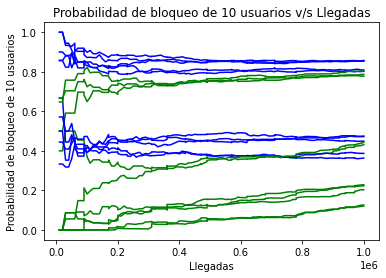

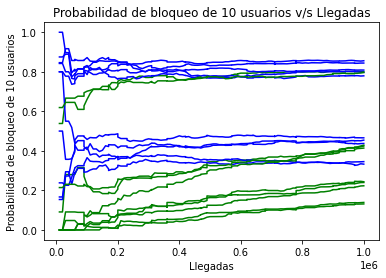

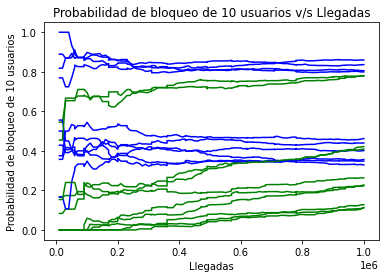

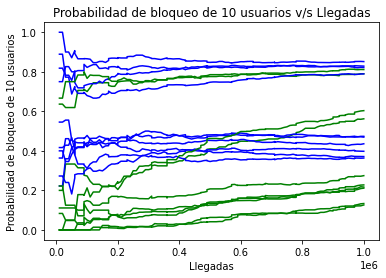

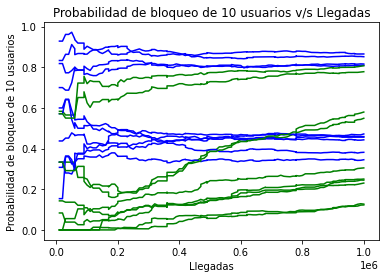

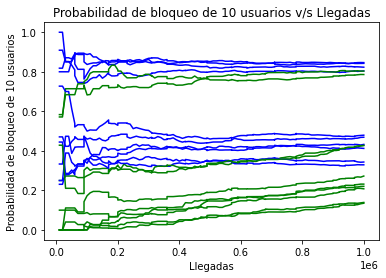

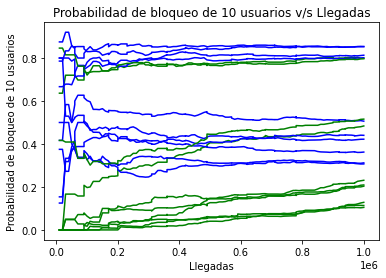

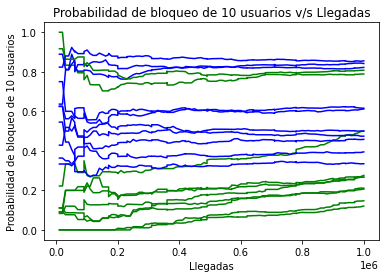

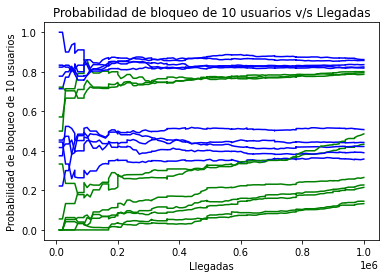

Para usuario: 0 Gana camino más corto
Para usuario: 1 Gana balance de carga
Para usuario: 2 Gana balance de carga
Para usuario: 3 Gana balance de carga
Para usuario: 4 Gana balance de carga
Para usuario: 5 Gana balance de carga
Para usuario: 6 Gana balance de carga
Para usuario: 7 Gana balance de carga
Para usuario: 8 Gana camino más corto
Para usuario: 9 Gana camino más corto
Para usuario: 10 Gana camino más corto
Para usuario: 11 Gana balance de carga
Para usuario: 12 Gana balance de carga
Para usuario: 13 Gana balance de carga
Para usuario: 14 Gana camino más corto
Para usuario: 15 Gana camino más corto
Para usuario: 16 Gana balance de carga
Para usuario: 17 Gana balance de carga
Para usuario: 18 Gana balance de carga
Para usuario: 19 Gana camino más corto
Para usuario: 20 Gana camino más corto
Para usuario: 21 Gana balance de carga
Para usuario: 22 Gana balance de carga
Para usuario: 23 Gana camino más corto
Para usuario: 24 Gana camino más corto
Para usuario: 25 Gana camino más co

In [12]:
for uid in range(int(M/10)):
    start = uid * 10
    end = (uid + 1) * 10
    plts.plt_10users(balanced_data[4], balanced_data[1][start:end], non_balanced_data[1][start:end])
for uid in range(M):
    if balanced_data[1][uid][-1] < non_balanced_data[1][uid][-1]: output = "balance de carga"
    else: output = "camino más corto"
    print("Para usuario:", uid, "Gana", output)
    #plt.plt_user(balanced_data, non_balanced_data, uid)

130


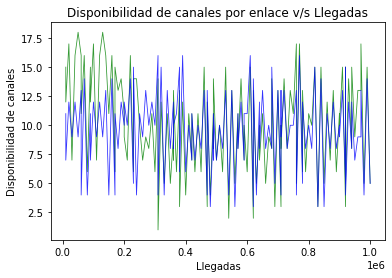

130


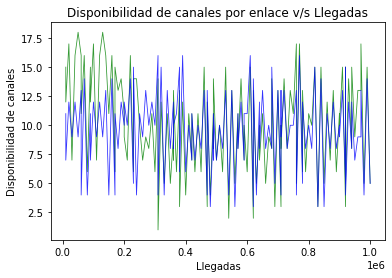

130


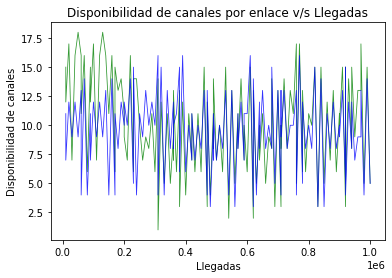

130


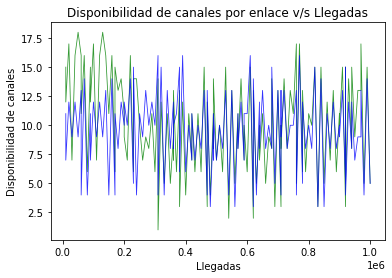

130


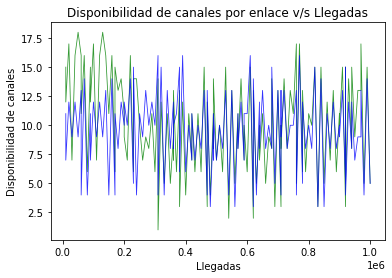

130


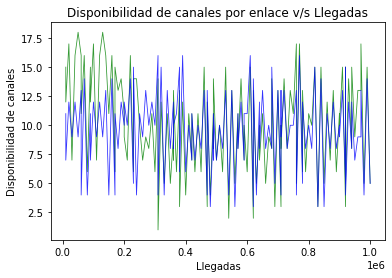

130


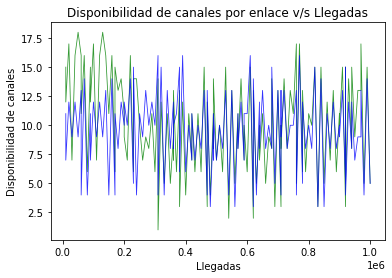

130


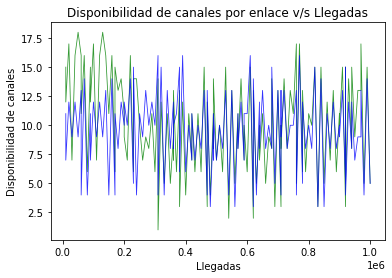

130


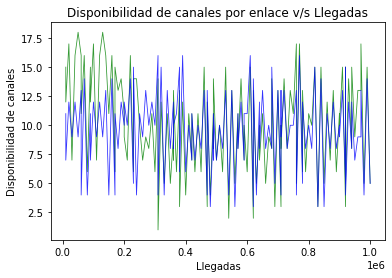

130


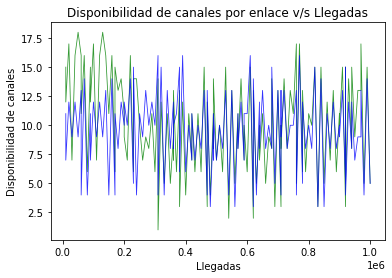

In [10]:
for _link in range(N):
    plts.plt_link(balanced_data, non_balanced_data, _link)


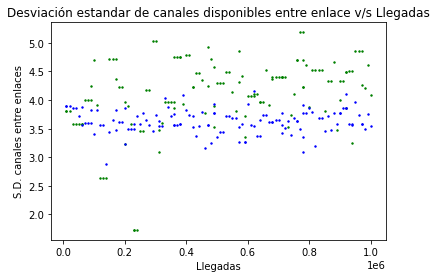

In [11]:
plts.plt_stdev(balanced_data, non_balanced_data)

### Conclusiones

